In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import networkx as nx
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

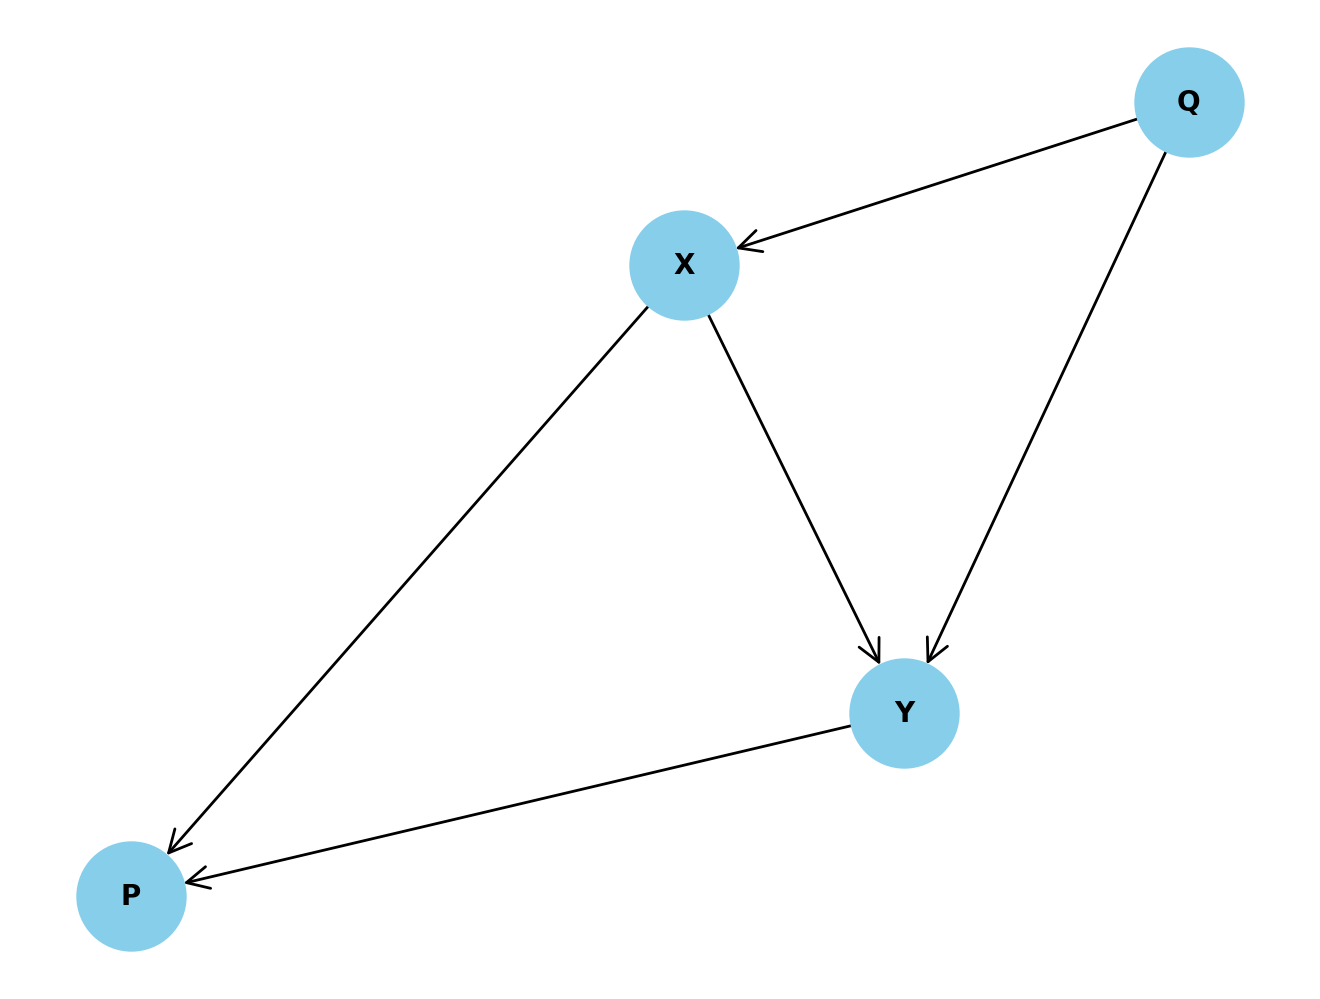

In [3]:
graph = nx.DiGraph()
#graph.add_edges_from([("root", "a"), ("a", "b"), ("a", "e"), ("b", "c"), ("b", "d"), ("d", "e")])
graph.add_edges_from([("X", "Y"), ("X", "P"), ("Y", "P"), ("Q", "X"), ("Q", "Y")])

# Draw the graph
pos = nx.spring_layout(graph, seed=42)  # Position nodes using spring layout algorithm
nx.draw(graph, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20, arrowstyle="->")
plt.show()

In [4]:
N = 5_000
Q = rng.normal(size=N)
X = rng.normal(loc=0.14*Q, scale=0.4, size=N)
Y = rng.normal(loc=0.7*X + 0.11*Q, scale=0.24, size=N)
P = rng.normal(loc=0.43*X + 0.21*Y, scale=0.22, size=N)
df = pd.DataFrame({"Q": Q, "X": X, "Y": Y, "P": P})

df.head()

,Q,X,Y,P
0,0.304717,-0.060520,0.033461,0.185277
1,-1.039984,-0.265392,-0.084383,0.079660
2,0.750451,-0.173601,-0.392316,0.007946
3,0.940565,0.303072,0.247141,0.279045
4,-1.951035,-0.179286,-0.141118,-0.015906


In [5]:
model = bmb.Model("Y ~ X", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:06.460092
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.914221
Transforming variables...
Transformation time =  0:00:00.016005
Computing Log Likelihood...


Log Likelihood time =  0:00:00.815579


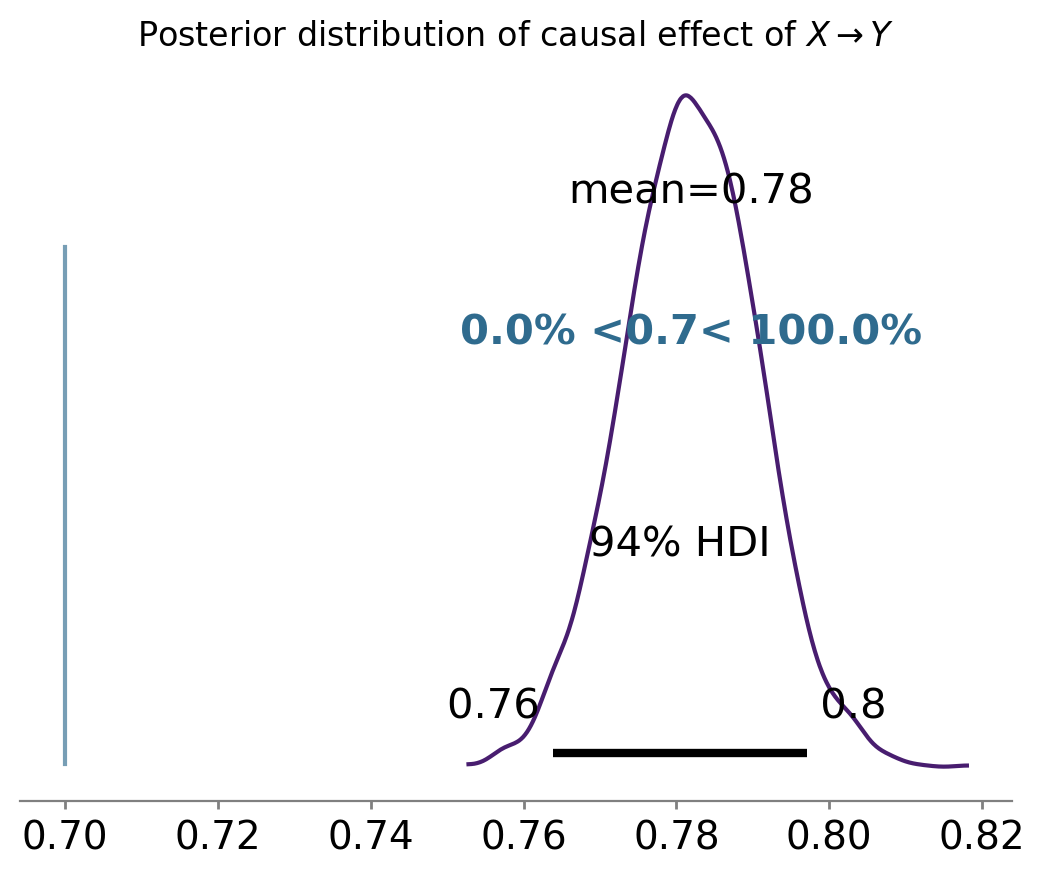

In [6]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

In [7]:
model = bmb.Model("Y ~ Q + X + P", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:02.430897
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.285623
Transforming variables...
Transformation time =  0:00:00.005169
Computing Log Likelihood...


Log Likelihood time =  0:00:00.518167


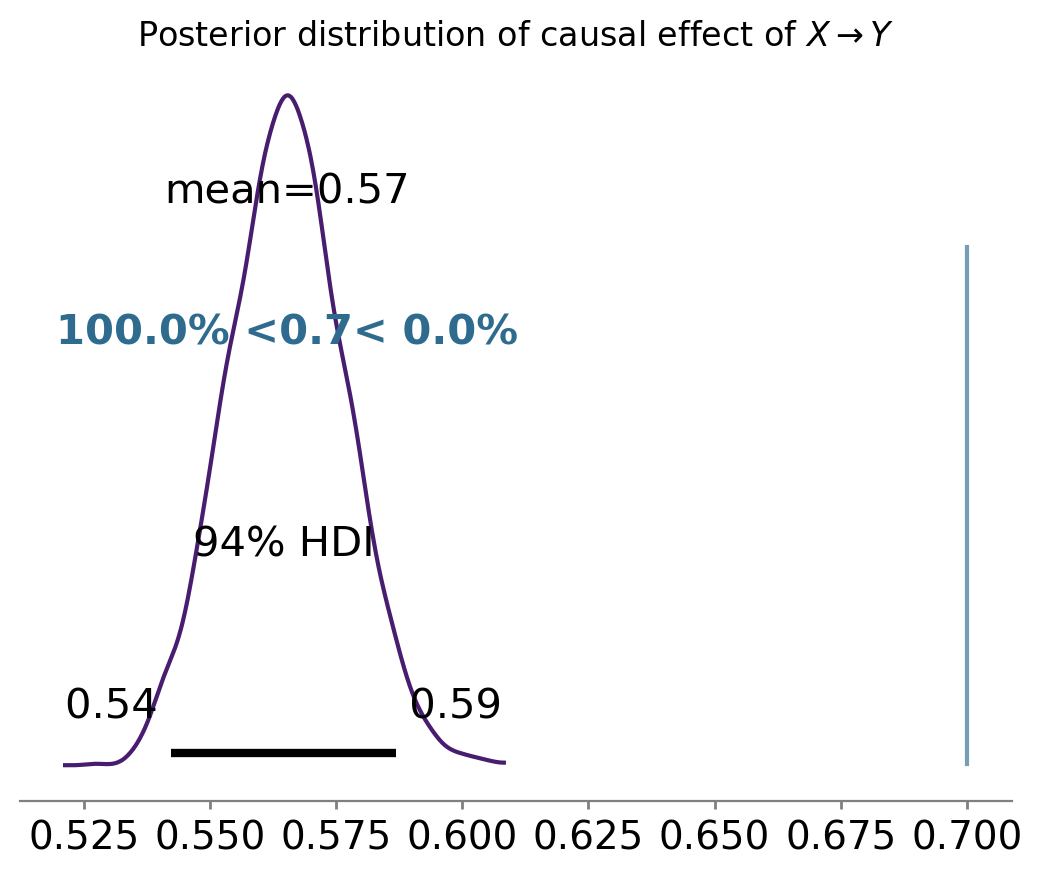

In [8]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

In [9]:
model = bmb.Model("Y ~ X + Q", df)
results = model.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:01.313609
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.952081
Transforming variables...
Transformation time =  0:00:00.004725
Computing Log Likelihood...


Log Likelihood time =  0:00:00.595064


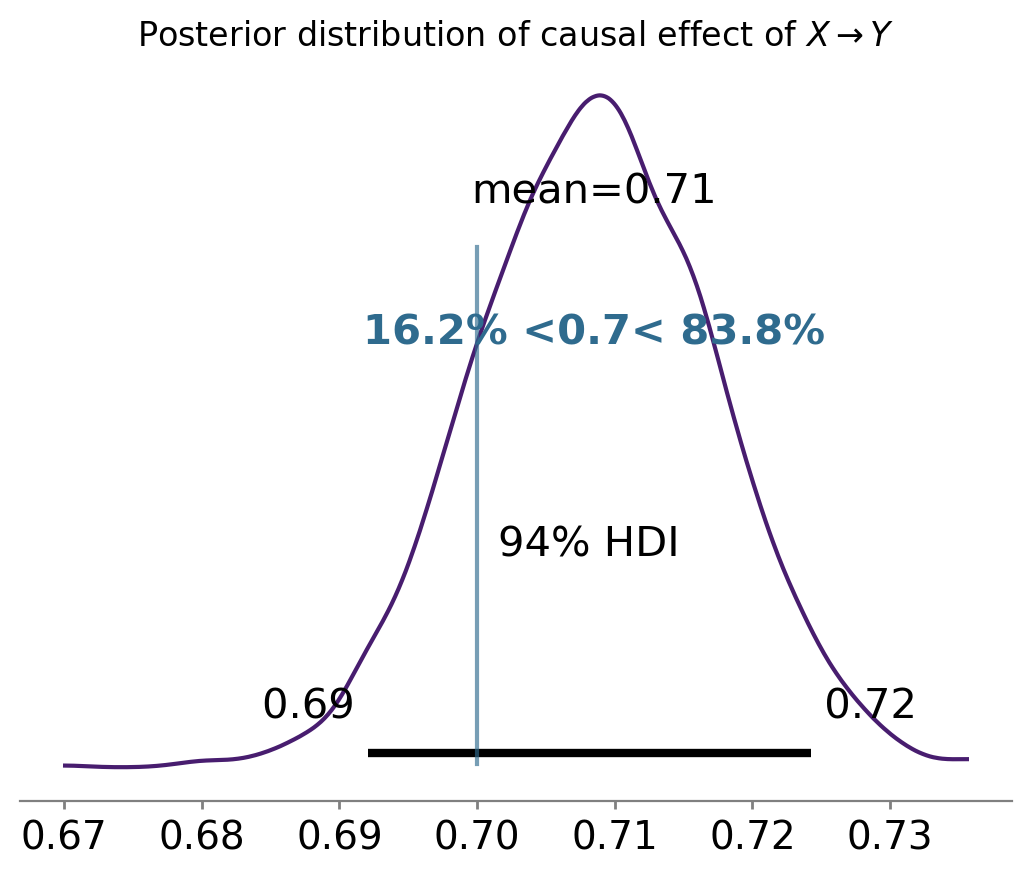

In [10]:
ax = az.plot_posterior(results.posterior["X"], ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

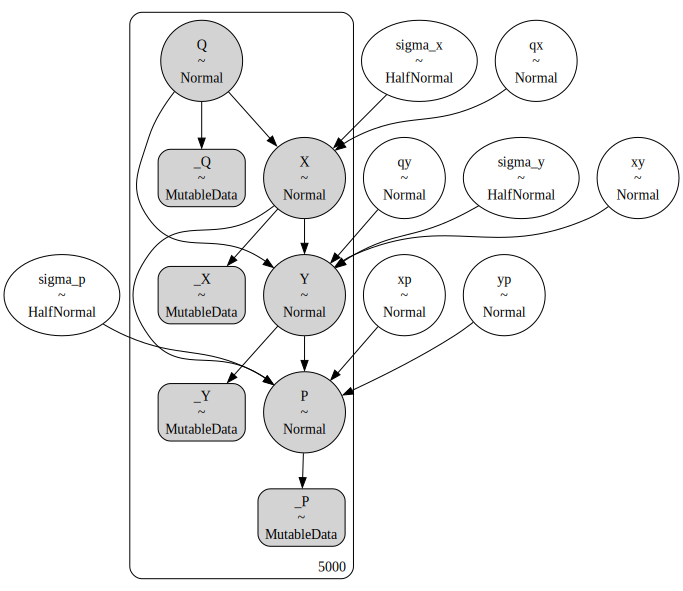

In [11]:
with pm.Model() as model:
    # data
    _Q = pm.MutableData("_Q", df["Q"])
    _X = pm.MutableData("_X", df["X"])
    _Y = pm.MutableData("_Y", df["Y"])
    _P = pm.MutableData("_P", df["P"])

    # priors on slopes
    # x ~ q
    qx = pm.Normal("qx")
    # y ~ x + q
    xy = pm.Normal("xy")
    qy = pm.Normal("qy")
    # p ~ x + y
    xp = pm.Normal("xp")
    yp = pm.Normal("yp")

    # priors on sd's
    sigma_x = pm.HalfNormal("sigma_x")
    sigma_y = pm.HalfNormal("sigma_y")
    sigma_p = pm.HalfNormal("sigma_p")
    
    # model
    Q = pm.Normal("Q", observed=_Q)
    X = pm.Normal("X", mu=qx*Q, sigma=sigma_x, observed=_X)
    Y = pm.Normal("Y", mu=xy*X + qy*Q, sigma=sigma_y, observed=_Y)
    P = pm.Normal("P", mu=xp*X + yp*Y, sigma=sigma_p, observed=_P)

pm.model_to_graphviz(model)

In [12]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:05.803776
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.371978
Transforming variables...
Transformation time =  0:00:00.006901
Computing Log Likelihood...


Log Likelihood time =  0:00:01.433417


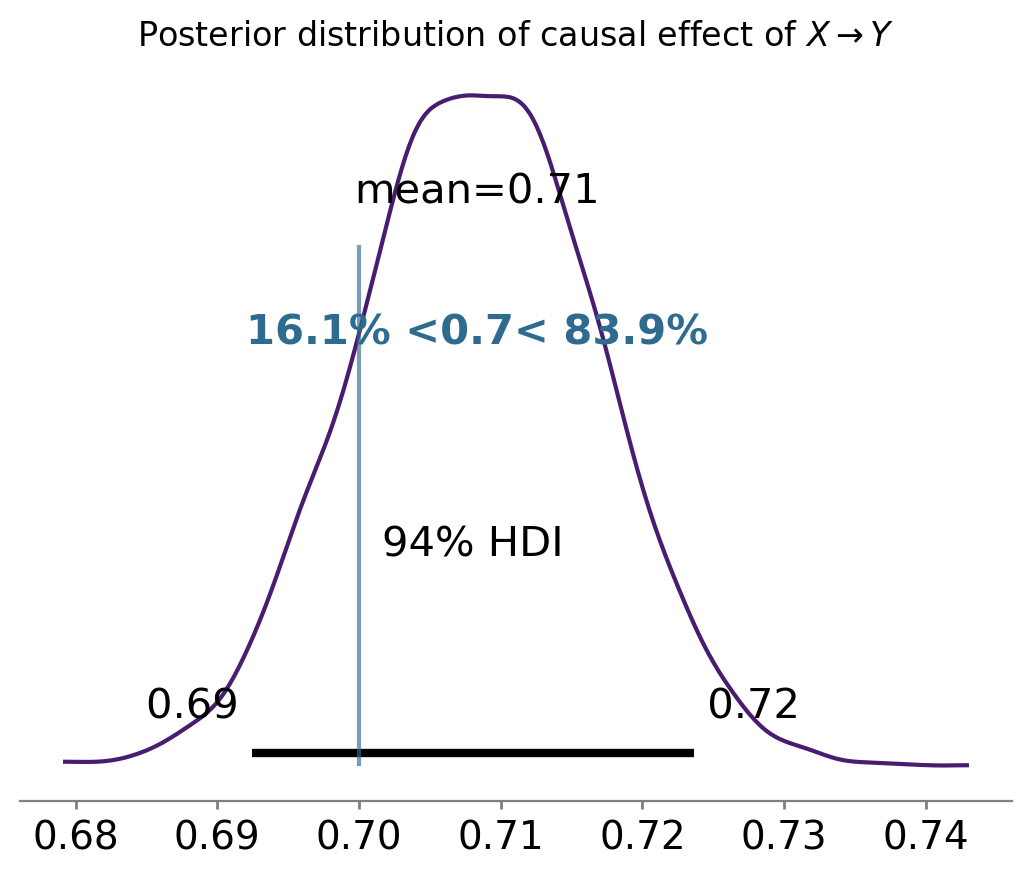

In [13]:
ax = az.plot_posterior(idata, var_names="xy", ref_val=0.7)
ax.set_title(r"Posterior distribution of causal effect of $X \rightarrow Y$");

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.12.3

bambi     : 0.12.0
arviz     : 0.16.0
scipy     : 1.10.1
pandas    : 2.0.3
numpy     : 1.25.2
matplotlib: 3.7.2
seaborn   : 0.12.2
pymc      : 5.6.1
networkx  : 3.1

Watermark: 2.4.3

